In [77]:
using Distributions
using ProfileView
using StatsFuns
using Gadfly
using ProgressMeter
using DataFrames

In [78]:
blas_set_num_threads(4)

In [79]:
type Individual
    m::Int64
    p::Int64
    v_e::Float64
    mu::Float64
    mu_b::Float64
    mu_sigma::Float64
    y::Array{Float64, 1}
    b::Array{Int64, 2}
    x::Array{Float64, 1}
    z::Array{Float64, 1}
    
    Individual(m, p, v_e, mu, mu_b, mu_sigma) = new(2*m, p, v_e, mu, mu_b, mu_sigma)
end  

type Population
    n::Int64
    base_ind::Individual
    generation::Int64
    fitness::Array{Float64, 1}
    surface::Distributions.MvNormal{PDMats.PDMat,Array{Float64,1}}
    pop::Array{Individual, 1}
    Population(n, base_ind, generation) = new(n, base_ind, generation)
end

In [80]:
function Population(n::Int, ind::Individual, pop_array::Array{Individual, 1})
    new_pop = Population(n, ind, 0)
    new_pop.generation = 0
    new_pop.pop = pop_array
    new_pop
end

function RandomInd!(ind::Individual, y_mean::Float64 = 0.0, g_sigma::Float64 = ind.mu_sigma)
    ind.y = rand(Normal(y_mean, g_sigma), ind.m)
    ind.b = rand(Bernoulli(), ind.p, ind.m)
    ind.x = ind.b * ind.y
    ind.z = ind.x + rand(Normal(0, ind.v_e), ind.p)
end

function RandomInd(ind::Individual, y_mean::Float64 = 0.0, g_sigma::Float64 = ind.mu_sigma)
    new_ind = Individual(ind.m/2, ind.p, ind.v_e, ind.mu, ind.mu_b, ind.mu_sigma)
    RandomInd!(new_ind, y_mean, g_sigma)
    new_ind
end

function RandomPop!(pop::Population, y_mean::Float64 = 0.0, g_sigma::Float64 = ind.mu_sigma)
    pop.pop = Array(Individual, pop.n)
    pop.generation = 0
    for i = 1:pop.n
        pop.pop[i] = RandomInd(pop.base_ind, y_mean, g_sigma)
    end
    pop.fitness = zeros(Float64, pop.n)
end


import Base.getindex
import Base.copy

function getindex(pop::Population, i::Integer)
    getindex(pop.pop, i)
end

function getindex(pop::Population, s::UnitRange)
    Population(length(s), pop.base_ind, getindex(pop.pop, s))
end

function append!(pop::Population, ind::Individual)
    pop.pop = [pop.pop; ind]
    pop.n = length(pop.pop)
end

function append!(pop1::Population, pop2::Population)
    # COMPARE BASE IND!
    pop1.pop = [pop1.pop; pop2.pop]
    pop.n = length(pop1.pop)
end

function join(pop1::Population, pop2::Population)
    # TODO: COMPARE BASE IND!
    new_pop = Population(pop1.n + pop2.n, pop1.base_ind)
    new_pop.pop = [pop1.pop; pop2.pop]
    new_pop
end

function copy!(source::Population, sink::Population)
    sink.n = source.n
    sink.base_ind = source.base_ind
    sink.generation = source.generation
    sink.fitness = source.fitness
    sink.surface = source.surface
    sink.pop = source.pop
end

function copy(source::Population)
    new_pop = Population(source.n, source.base_ind, source.generation)
    copy!(source, new_pop)
    new_pop
end
    
function mutation!(ind::Individual, bin_y, bin_b)
    mutation_y = rand(bin_y)
    if(mutation_y > 0)
        d_uni_y = DiscreteUniform(1, ind.m)
        norm_sigma = Normal(0, ind.mu_sigma)
        for k = range(1, mutation_y)
            i = rand(d_uni_y)
            ind.y[i] = ind.y[i] + rand(norm_sigma)
        end
    end
    mutation_b = rand(bin_b)
    if(mutation_b > 0)
        d_uni_p = DiscreteUniform(1, ind.p)
        d_uni_m = DiscreteUniform(1, ind.m)
        for k = range(1, mutation_b)
            i = rand(d_uni_p)
            j = rand(d_uni_m)
            ind.b[i,j] = ind.b[i, j] == 1 ? 0 : 1
        end
    end
end

function mutation!(pop::Population)
    bin_y = Binomial(ind.m, ind.mu)
    bin_b = Binomial(ind.m * ind.p, ind.mu_b)
    for k = 1:pop.n
        mutation!(pop.pop[k], bin_y, bin_b)
    end
end

function fitness!(pop::Population)
    logfit = Float64[logpdf(pop.surface, pop[i].z) for i in 1:pop.n]
    pop.fitness = exp(logfit - logsumexp(logfit))
end

function changeSurface!(pop::Population, theta::Array{Float64, 1}, omega::Array{Float64, 2})
    pop.surface = MvNormal(theta, omega)
end

function twoModuleMatrix(vars::Array{Float64, 1}, cor1, cor2)
    n = size(vars)[1]
    n_1 = Int(floor(n/2))
    module_1 = [ones(Float64, n_1); zeros(Float64, n - n_1)]
    module_2 = [zeros(Float64, n_1); ones(Float64, n - n_1)]
    omega = (module_1 * module_1') * cor1 + module_2 * module_2' * cor2
    omega * 0.8
    [omega[i, i] = 1 for i = 1:n]
    omega .* (sqrt(vars) * sqrt(vars)')
end

function cross!(ind_1::Individual, ind_2::Individual, new_ind::Individual,
                d_uni, norm_e, alele_1::Array{Int64, 1}, alele_2::Array{Int64, 1})
    rand!(d_uni, alele_1)
    rand!(d_uni, alele_2)
    for locus = range(2, 2, 5)
        @inbounds new_ind.y[   locus - 1] = ind_1.y[   (locus - 1) + alele_1[convert(Int64, locus/2)]]
        @inbounds new_ind.y[   locus]     = ind_2.y[   (locus - 1) + alele_2[convert(Int64, locus/2)]]
        @inbounds new_ind.b[:, locus - 1] = ind_1.b[:, (locus - 1) + alele_1[convert(Int64, locus/2)]]
        @inbounds new_ind.b[:, locus]     = ind_2.b[:, (locus - 1) + alele_2[convert(Int64, locus/2)]]
    end
    new_ind.x = new_ind.b * new_ind.y
    new_ind.z = new_ind.x + rand(norm_e, new_ind.p)
end

function choose_mates!(pop::Population, mates::Array{Int64, 1})
    matings = rand(Multinomial(pop.n, pop.fitness), 1)
    l = 1
    for k = 1:pop.n
        if(matings[k] > 0)
            for(i = 1:matings[k])
                mates[l] = k
                l = l + 1
            end
        end
    end
    round(Int64, shuffle!(mates))
end

function next_generation!(pop::Population, holder_pop::Population, sires, dames, d_uni, norm_e, alele_1, alele_2; selective = true)
    holder_pop.surface = pop.surface
    if (selective)
        fitness!(pop)
    else
        fill!(pop.fitness, 1./pop.n)
    end
    holder_pop.fitness = pop.fitness
    mutation!(pop)
    choose_mates!(pop, sires)
    choose_mates!(pop, dames)
    for i in 1:pop.n
        cross!(pop[sires[i]], pop[dames[i]], holder_pop.pop[i], d_uni, norm_e, alele_1, alele_2)
    end
    holder_pop.generation = pop.generation + 1
    copy!(holder_pop, pop)
end 

function moments(pop::Population)
    ys = convert(Array{Float64, 2}, reshape([ind.y[i] for ind in pop.pop, i in 1:pop.base_ind.m], pop.n, pop.base_ind.m))
    xs = convert(Array{Float64, 2}, reshape([ind.x[i] for ind in pop.pop, i in 1:pop.base_ind.p], pop.n, pop.base_ind.p))
    zs = convert(Array{Float64, 2}, reshape([ind.z[i] for ind in pop.pop, i in 1:pop.base_ind.p], pop.n, pop.base_ind.p))
    mean_b = zeros(Float64, pop.base_ind.p, pop.base_ind.m)
    for i in 1:pop.n
        mean_b = mean_b + pop[i].b
    end
    mean_y = squeeze(mean(ys, 1), 1)
    mean_x = squeeze(mean(xs, 1), 1)
    mean_z = squeeze(mean(zs, 1), 1)
    mean_b = mean_b / pop.n

    P = cov(zs)
    G = cov(xs)
    h2 = diag(G)./diag(P)
    corrG = cor(xs)
    corrP = cor(zs)

    Dict([("mean_y", mean_y), 
          ("mean_b", mean_b), 
          ("mean_x", mean_x),
          ("mean_z", mean_z), 
          ("P", P), 
          ("G", G), 
          ("h2", h2), 
          ("corrG", corrG),
          ("corrP", corrP)])
end

moments (generic function with 1 method)

In [115]:
function run_pop(gen_drift, gen_stab, gen_direc, thin = 100)
    global ind = Individual(200, 4, 0.8, 0.0005, 0.0001, 0.02)
    pop = Population(2500, ind, 0)
    RandomPop!(pop)
    theta = 8*ones(Float64, ind.p)
    omega_var = 10

    omega = twoModuleMatrix(omega_var*ones(Float64, ind.p), 0, 0)
    changeSurface!(pop, theta, omega)
    fitness!(pop)
    holder_pop = copy(pop)
    
    delta_theta_speed = 0.005
    delta_theta = delta_theta_speed * [ones(Float64, Int64(ind.p/2)); -1 * ones(Float64, Int64(ind.p/2))]
     
    sires = zeros(Int64, pop.n)
    dames = zeros(Int64, pop.n)
    d_uni = DiscreteUniform(0, 1)
    norm_e  = Normal(0, pop.base_ind.v_e)
    alele_1 = zeros(Int64, Int64(pop.base_ind.m/2))
    alele_2 = zeros(Int64, Int64(pop.base_ind.m/2))
    
    moments_array = []
    
    @showprogress 2 "Drift: " for i = 1:gen_drift
        if(i % thin == 0) 
            moments_array = [moments_array; moments(pop)]
        end
        next_generation!(pop, holder_pop, sires, dames, d_uni, norm_e, alele_1, alele_2, selective = false)
    end
    
    @showprogress 2 "Stabilizing Selection: " for i = 1:gen_stab
        if(i % thin == 0) 
            moments_array = [moments_array; moments(pop)]
        end
        next_generation!(pop, holder_pop, sires, dames, d_uni, norm_e, alele_1, alele_2, selective = true)
    end
    
    omega = twoModuleMatrix(omega_var*ones(Float64, ind.p), 0.8, 0.8)
    
    @showprogress 2 "Directional Selection: " for i = 1:gen_direc
        if(i % thin == 0) 
            moments_array = [moments_array; moments(pop)]
        end
        theta += delta_theta
        changeSurface!(pop, theta, omega)
        next_generation!(pop, holder_pop, sires, dames, d_uni, norm_e, alele_1, alele_2, selective = true)
    end
    Dict([("moments", moments_array),
          ("pop"    , pop)])
end

run_pop (generic function with 2 methods)

In [116]:
warm_up = run_pop(1, 1, 1)
0

0

In [117]:
pop_dict = run_pop(10000, 12000, 0, 10)
0

Drift: 100% Time: 0:07:39
Stabilizing Selection: 100% Time: 0:09:34

0

In [118]:
pop, pop_moments = (pop_dict["pop"], pop_dict["moments"])
pop_moments[end]["mean_z"]

4-element Array{Float64,1}:
 6.97726
 7.03301
 7.05138
 7.076  

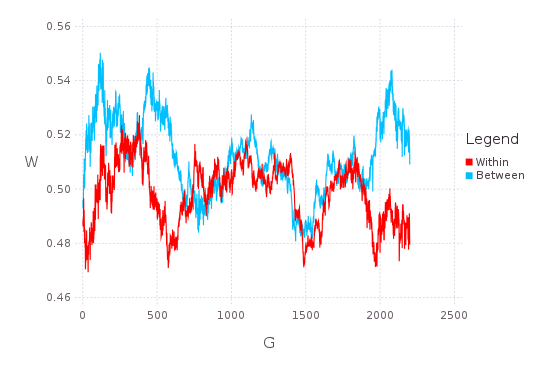

In [119]:
n = size(pop_moments)[1]
df = DataFrame(W = [pop_moments[i]["corrG"][1, 2] for i in 1:n],
               B = [pop_moments[i]["corrG"][1, end] for i in 1:n],
               G = collect(1:n) )
plot(df, layer(y="W", x="G", Geom.line, Theme(default_color=colorant"red")),
         layer(y="B", x="G", Geom.line),
Guide.manual_color_key("Legend", ["Within", "Between"], ["red", "deepskyblue"]))

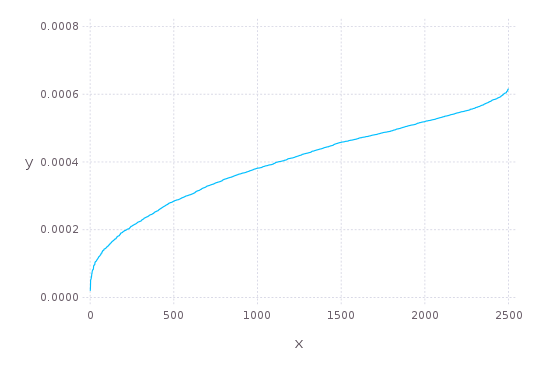

In [120]:
plot(x = collect(1:pop.n), y = sort(pop.fitness), Geom.line)

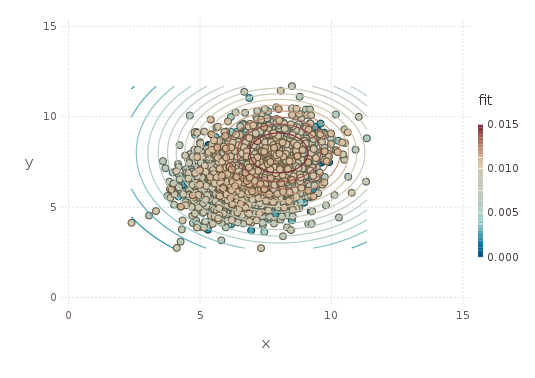

In [127]:
zs = convert(Array{Float64, 2}, reshape([ind.z[i] for ind in pop.pop, i in 1:pop.base_ind.p], pop.n, pop.base_ind.p))
zs_eig = (eig(pop.surface.Σ.mat)[2][:, end-1:end]' * zs')'

zs_df = DataFrame(x = zs_eig[:,1], y = zs_eig[:,2], fit = pop.fitness)
sort!(zs_df,  cols = [:fit])

s_theta = eig(pop.surface.Σ.mat)[2][:, end-1:end]' * pop.surface.μ
s_omega = diagm(eig(pop.surface.Σ.mat)[1])[end-1:end,end-1:end]

limits_x = (reduce(min, [s_theta[1] - 0.5*sqrt(s_omega[1, 1]); zs_eig[:,1]]),
            reduce(max, [s_theta[1] + 0.5*sqrt(s_omega[1, 1]); zs_eig[:,1]]))
limits_y = (reduce(min, [s_theta[2] - 0.5*sqrt(s_omega[2, 2]); zs_eig[:,2]]),
            reduce(max, [s_theta[2] + 0.5*sqrt(s_omega[2, 2]); zs_eig[:,2]]))

plot(layer(z = (x,y) -> pdf(MvNormal(s_theta, s_omega), [x; y]),
           x = linspace(limits_x[1], limits_x[2],150), y = linspace(limits_y[1], limits_y[2],150), 
           Geom.contour),
     layer(zs_df, x = "x", y = "y", color = "fit", Geom.point))

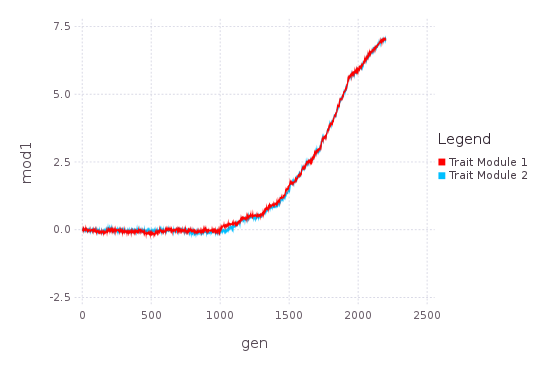

In [122]:
n = size(pop_moments)[1]
df_trait = DataFrame(mod1 = [pop_moments[i]["mean_z"][1]   for i in 1:n],
                     mod2 = [pop_moments[i]["mean_z"][end] for i in 1:n],
                      gen = collect(1:n) )
plot(df_trait, layer(y="mod1", x="gen", Geom.line, Theme(default_color=colorant"red")),
layer(y="mod2", x="gen", Geom.line),
     Guide.manual_color_key("Legend", ["Trait Module 1", "Trait Module 2"], ["red", "deepskyblue"]))

In [123]:
eig(pop.surface.Σ.mat)[2][:, end-1:end]' * pop_moments[end]["mean_z"]

2-element Array{Float64,1}:
 7.05138
 7.076  

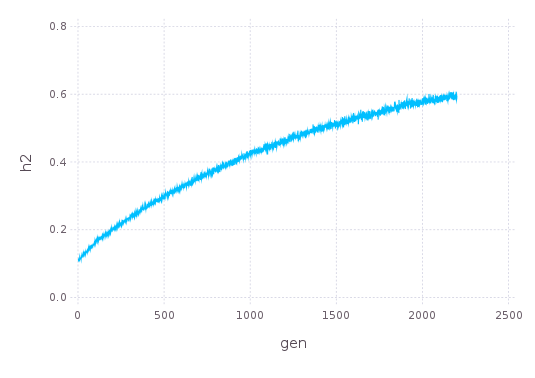

In [124]:
n = size(pop_moments)[1]
df_trait = DataFrame(P = [pop_moments[i]["P"][1, 1] for i in 1:n],
h2 = [mean(pop_moments[i]["h2"]) for i in 1:n],
                     gen = collect(1:n) )
plot(df_trait, layer(y="h2", x="gen", Geom.line))

2200-element Array{Any,1}:
 0.110899
 0.11166 
 0.110073
 0.112448
 0.110582
 0.111781
 0.111104
 0.112799
 0.111298
 0.117431
 0.113724
 0.113498
 0.113847
 ⋮       
 0.589907
 0.60008 
 0.595199
 0.592527
 0.597606
 0.602104
 0.591393
 0.607477
 0.602991
 0.584231
 0.586713
 0.596318